In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [301]:
img1 = cv2.imread("frames/frame_0000.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("frames/frame_0001.jpg", cv2.IMREAD_GRAYSCALE)


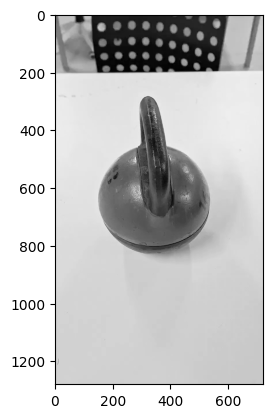

In [302]:
plt.imshow(img1, cmap="Greys_r")

In [305]:
sift = cv2.SIFT_create() 
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# orb = cv2.ORB_create()
# kp1, des1 = orb.detectAndCompute(img1, None)
# kp2, des2 = orb.detectAndCompute(img2, None)


(np.float64(-0.5), np.float64(719.5), np.float64(1279.5), np.float64(-0.5))

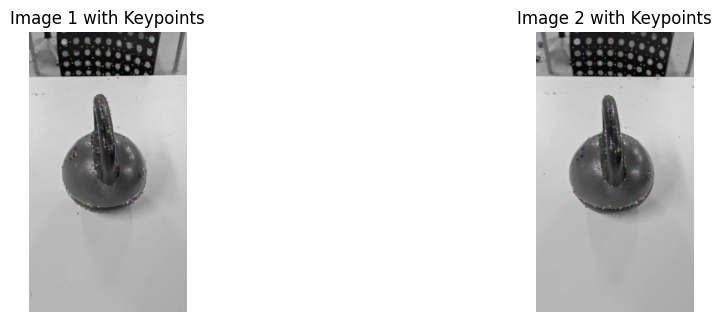

In [306]:
img1_with_kp = cv2.drawKeypoints(img1, kp1, None)
img2_with_kp = cv2.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(12, 8))

# Subplot for first image with keypoints
ax1 = plt.subplot(221)
ax1.imshow(cv2.cvtColor(img1_with_kp, cv2.COLOR_BGR2RGB))
ax1.set_title('Image 1 with Keypoints')
ax1.axis('off')

# Subplot for second image with keypoints
ax2 = plt.subplot(222)
ax2.imshow(cv2.cvtColor(img2_with_kp, cv2.COLOR_BGR2RGB))
ax2.set_title('Image 2 with Keypoints')
ax2.axis('off')

In [307]:
# index_params = dict(algorithm=0, trees=5) 
# search_params = dict(checks=50)
  
# flann = cv2.FlannBasedMatcher(index_params, search_params) 
  
# matches = flann.knnMatch(des1, des2, k=2) 
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

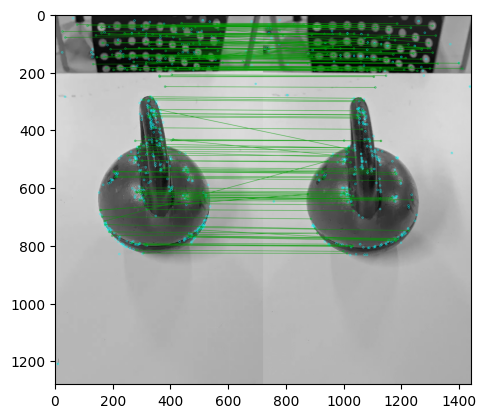

In [308]:
good_matches = [[0, 0] for _ in range(len(matches))] 

# Good matches 
for i, (m, n) in enumerate(matches): 
    if m.distance < 0.75*n.distance: 
        good_matches[i] = [1, 0] 

  
# Draw the matches using drawMatchesKnn() 
matched = cv2.drawMatchesKnn(img1, 
                             kp1, 
                             img2, 
                             kp2, 
                             matches,
                             outImg=None, 
                             matchColor=(0, 155, 0), 
                             singlePointColor=(0, 255, 255), 
                             matchesMask=good_matches, 
                             flags=0
                             ) 

plt.imshow(matched)

In [309]:
good_matches1 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches1.append(m)

# Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches1]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches1]).reshape(-1, 1, 2)


In [310]:
# Estimate fundamental matrix using RANSAC
fundamental_matrix, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 4, 0.99)
# Essential Matrix Estimation
K = np.array([[1000, 0, 500], [0, 1000, 300], [0, 0, 1]]) # Camera matrix
essential_matrix = K.T @ fundamental_matrix @ K

In [311]:
# Camera Pose Estimation
retval, R, t, mask = cv2.recoverPose(essential_matrix, pts1, pts2, K)

In [312]:
points3D = cv2.triangulatePoints(np.hstack((np.eye(3), np.zeros((3,1)))), np.hstack((R,t)), pts1, pts2)

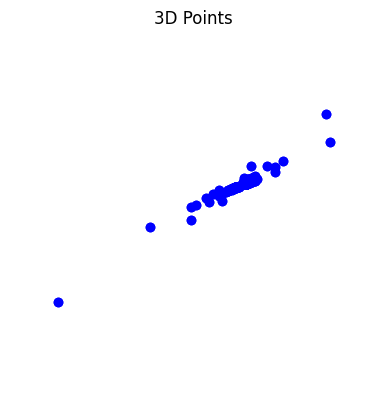

Number of matched keypoints: 174


In [313]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(223, projection='3d')
normalized_object_points = points3D / points3D[3]

# Plot 3D points
for i in range(normalized_object_points.shape[1]):
    ax.plot([normalized_object_points[0, i], normalized_object_points[0, i]], 
            [normalized_object_points[1, i], normalized_object_points[1, i]], 
            [normalized_object_points[2, i], normalized_object_points[2, i]], 'bo-', linewidth=0.5)

plt.title('3D Points')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Number of matched keypoints:", len(good_matches1))

In [260]:
import cv2
import os

def extract_frames(video_path, output_dir, frame_skip=5):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    extracted_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_skip == 0:
            frame_path = os.path.join(output_dir, f"frame_{extracted_frames:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            extracted_frames += 1
        frame_id += 1

    cap.release()
    print(f"Extracted {extracted_frames} frames to {output_dir}")
    return output_dir


video_path = "video.mp4"
output_dir = "frames"

extract_frames(video_path, output_dir)


Extracted 80 frames to frames


'frames'

In [269]:
images = []
folder_path = "frames"
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)

In [281]:
def process_pair(im1, im2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract matched keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # K = np.array([[1000, 0, 500], [0, 1000, 300], [0, 0, 1]]) # Camera matrix
    K = np.eye(3)
    fundamental_matrix, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 4, 0.99)
    essential_matrix = K.T @ fundamental_matrix @ K
    _, R, t, _ = cv2.recoverPose(essential_matrix, pts1, pts2, K)
    points3D = cv2.triangulatePoints(np.hstack((np.eye(3), np.zeros((3,1)))), np.hstack((R,t)), pts1, pts2)
    return points3D

In [315]:
def sfm(images):
    all_points_3d = []
    for i in range(len(images) - 1):
        points_3d = process_pair(images[i], images[i+1])
        points_3d /= points_3d[3]
        all_points_3d.append(points_3d[:3].T)

    all_points_3d = np.vstack(all_points_3d) # Convert list to numpy array

    return all_points_3d

In [316]:
def plot_3d_points(points3D):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], c='r', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Triangulated 3D Points')
    plt.show()

In [317]:
points3D = sfm(images)

TypeError: process_pair() missing 1 required positional argument: 'K'

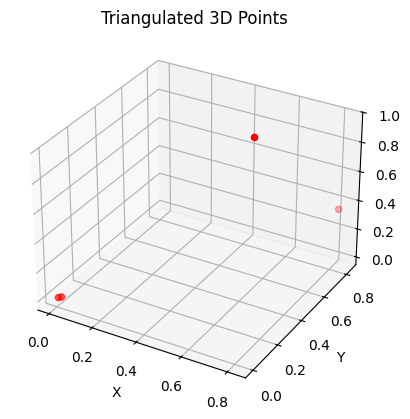

In [318]:
plot_3d_points(points3D)

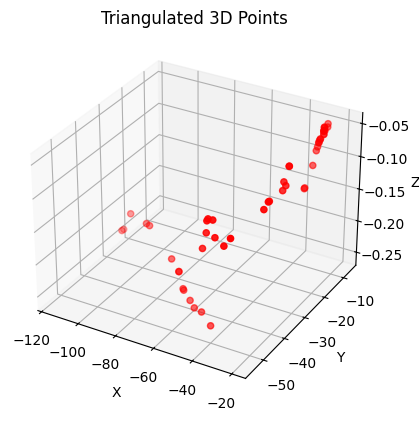

In [314]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def process_pair(im1, im2, K):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance: 
            good_matches.append(m)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    try:
        fundamental_matrix, _ = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 4, 0.99)
        essential_matrix = K.T @ fundamental_matrix @ K
        _, R, t, _ = cv2.recoverPose(essential_matrix, pts1, pts2, K)
        points3D = cv2.triangulatePoints(np.hstack((np.eye(3), np.zeros((3, 1)))), np.hstack((R, t)), pts1, pts2)
        return points3D
    except Exception as e:
        print(f"Error processing image pair: {e}")
        return None

def sfm(images, K):
    all_points_3d = []
    for i in range(len(images) - 1):
        points_3d = process_pair(images[i], images[i + 1], K)
        if points_3d is not None:
            points_3d /= points_3d[3, :]
            all_points_3d.append(points_3d[:3, :].T)
        
    all_points_3d = np.vstack(all_points_3d)
    return all_points_3d


def plot_3d_points(points3D):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], c='r', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Triangulated 3D Points')
    plt.show()


K = np.array([[1000, 0, 500], [0, 1000, 300], [0, 0, 1]])
all_points_3d = sfm(images[:3], K)
plot_3d_points(all_points_3d)